In [63]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import matplotlib.animation as animation

In [87]:
import torch

class CellSystem(torch.nn.Module):
    def __init__(self, num_cells=3):
        super().__init__()
        
        self.num_cells = num_cells  # Number of cells
        self.coefficients = torch.rand(num_cells, 4)  # [x, y, radius, spring_constant]
        
        # Movement matrix for rotational motion + inward contraction
        self.movement = torch.tensor([
            [0.0, -1.0],  # dx/dt = -y (rotation)
            [1.0,  0.0]   # dy/dt = x  (rotation)
        ]) - 0.2 * torch.eye(2)  # Inward contraction for spiral

    def forward(self, t, state):
        # Compute velocity from the movement matrix (rotation + contraction)
        velocity = torch.matmul(state, self.movement.T)
        
        # Initialize repelling force matrix (each cell will repel every other cell)
        repelling_forces = torch.zeros_like(state)  # Initialize repelling forces to zero

        # Loop over all pairs of cells to calculate repelling forces
        for i in range(self.num_cells):
            for j in range(i + 1, self.num_cells):  # Ensure no duplicate pairs
                # Calculate displacement between cell i and j
                displacement = state[j] - state[i]  # Vector from cell i to cell j
                distance = torch.norm(displacement) + 1e-6  # Avoid division by zero
                
                # Calculate radii and spring constants for both cells
                r_i, k_i = self.coefficients[i, 2], self.coefficients[i, 3]
                r_j, k_j = self.coefficients[j, 2], self.coefficients[j, 3]
                
                # Repelling force: Hooke's law based on distance, radii, and spring constants
                if distance < r_i + r_j:  # If distance is less than the sum of their radii
                    repelling_force = (k_i * (1.0 / distance - 1.0 / (r_i + r_j))) * (displacement / distance) * 2  # Adjust the force

                    # Apply repelling forces to both cells
                    repelling_forces[i] -= repelling_force
                    repelling_forces[j] += repelling_force
        
        # Add the repelling forces to the velocity (each cell gets adjusted)
        velocity += repelling_forces
        
        # Positions should be updated based on velocity, we return the updated velocity
        return velocity


In [95]:
import torch
from torchdiffeq import odeint

# Create model with a dynamic number of cells
num_cells = 3  # Change this number as needed
model = CellSystem(num_cells=num_cells)

# Dynamically create random initial positions within the [-1, 1] box for each cell
initial_state = 2 * torch.rand(num_cells, 2) - 1  # Random values between [-1, 1]

# Ensure initial_state has the shape (num_cells, 2)
assert initial_state.shape == (model.num_cells, 2), "Initial state dimensions mismatch."

# Time points (0 to 15 seconds, 150 points for smoother visualization)
t = torch.linspace(0, 15, 150)

# Solve ODE
with torch.no_grad():
    states = odeint(model, initial_state, t)

# Check the shapes and plot the results
print(states.shape)  # Should be (num_time_steps, num_cells, 2)

# Extract positions and plot the trajectories
positions = states  # Positions over time


torch.Size([150, 3, 2])


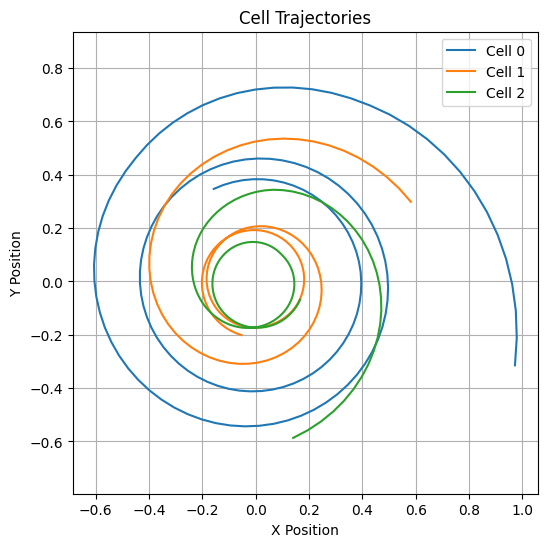

In [96]:
import matplotlib.pyplot as plt

# Plot the trajectories
plt.figure(figsize=(6, 6))
for cell_id in range(num_cells):
    cell_positions = positions[:, cell_id, :]  # Get positions for each cell
    plt.plot(cell_positions[:, 0], cell_positions[:, 1], label=f"Cell {cell_id}")

# Labels and legend
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Cell Trajectories")
plt.legend(loc='upper right')
plt.grid(True)
plt.axis("equal")  # Keep aspect ratio square
plt.show()